In [1]:
"""
Hybrid BO on the Franke surface: Random vs Baseline EI vs Dynamic-Prior + Curated Pool
=====================================================================================

What this script provides
-------------------------
- **Random**: uniform sampling over [0,1]^2.
- **Baseline BO (EI)**: standard SingleTaskGP + analytic EI (no prior).
- **Hybrid (this work)**: residual GP + **dynamic prior shaping** (m0 weight updates, optional 2D bumps)
  **and** a **curated candidate pool** per-iteration (anchors + Sobol candidates) where EI is evaluated.

Design notes
------------
- Minimal, modular, and self-contained (no external LLM call). A single stub `controller_decide(...)` can later
  be swapped for an actual LLM; its outputs already match the intended API.
- Prior mean m0(x) is implemented in torch and can include variable effects **and** a list of 2D Gaussian "bumps".
- Residual fitting uses least-squares calibration of α so the prior magnitude matches observed data scale; a
  per-iteration **m0_weight** gates the prior influence: `m0_scale = α * m0_weight`.
- The curated pool blends Sobol points with a few controller-proposed **anchors** (e.g., near incumbent and
  high-uncertainty zones). EI is evaluated on the pool; we pick the argmax (no gradient refine to keep code simple).

Usage (Jupyter)
---------------
```python
hist = compare_methods(n_init=6, n_iter=25, seed=0)
plot_runs(hist)
# or aggregate over seeds
hist_all = run_many_seeds(seeds=list(range(5)), n_init=6, n_iter=25)
plot_runs_mean(hist_all)
```

Dependencies
------------
- torch >=1.11, botorch, gpytorch, numpy, pandas, matplotlib
"""
import warnings
warnings.filterwarnings('ignore')

from __future__ import annotations

import math
from dataclasses import dataclass
from typing import Dict, Any, List, Tuple, Optional

import numpy as np
import pandas as pd

import torch
from torch import Tensor

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.optim.optimize import optimize_acqf
from botorch.posteriors.gpytorch import GPyTorchPosterior
from botorch.utils.sampling import draw_sobol_samples

import gpytorch
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal
from bo_anchor_prompts import SYS_PROMPT_ANCHORING_V2, FEW_SHOT_EXAMPLES



import httpx 
from openai import OpenAI
_OPENAI_CLIENT = OpenAI(http_client=httpx.Client(verify=False))
import json, os


# -------------------- Device / dtype --------------------
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
DTYPE = torch.float32
torch.set_default_dtype(DTYPE)

# -------------------- Franke surface --------------------

from franke import franke_hard_torch, franke_torch

# -------------------- Minimal prior ---------------------

from prior_gp import alignment_on_obs,fit_residual_gp, GPWithPriorMean, Prior

# -------------------- Controller (stub) ------------------

@dataclass
class Telemetry:
    t: int
    best: float
    imp_last_k: float
    rho: float
    alpha_ls: float

@dataclass
class Action:
    m0_weight: float                # in [0,1]
    anchors: List[List[float]]      # list of [x1,x2]
    add_bump: Optional[Dict[str, Any]] = None


def controller_decide(tele: Telemetry, X: Tensor, Y: Tensor, prior: Prior, gp_resid: SingleTaskGP) -> Action:
    # Rule-based placeholder for an LLM policy.
    if tele.rho < 0.0:
        w = 0.0
    elif tele.rho < 0.2:
        w = 0.3
    else:
        w = min(1.0, 0.5 + 0.4 * tele.rho)

    ibest = int(torch.argmax(Y))
    x_star = X[ibest].detach().cpu().tolist()

    with torch.no_grad():
        grid = draw_sobol_samples(bounds=torch.stack([torch.zeros(2, device=DEVICE, dtype=DTYPE),
                                                      torch.ones(2, device=DEVICE, dtype=DTYPE)]),
                                   n=256, q=1).squeeze(1).to(DEVICE)
        post = gp_resid.posterior(grid)
        var = post.variance.reshape(-1)
        topk = torch.topk(var, k=3).indices
    anchors = [x_star] + [grid[i].detach().cpu().tolist() for i in topk]

    bump = None
    if tele.imp_last_k < 1e-3 and tele.rho > 0.0:
        bump = {"mu": x_star, "sigma": 0.12, "amp": 0.12}

    return Action(m0_weight=float(w), anchors=anchors, add_bump=bump)


# -------------------- LLM readout (simple v1) ------------------
# A very small, first-pass implementation: we summarize the current BO state,
# ask the LLM for a structured readout (effects/interactions/bumps), and turn
# that into a Prior via readout_to_prior(). Keep it simple for debugging.


def summarize_bo_state_for_llm(gp: SingleTaskGP, X: Tensor, Y: Tensor, grid_n: int = 20, topk: int = 4) -> Dict[str, Any]:
    with torch.no_grad():
        xs = torch.linspace(0, 1, grid_n, device=DEVICE, dtype=DTYPE)
        xx, yy = torch.meshgrid(xs, xs, indexing="xy")
        grid = torch.stack([xx, yy], dim=-1).reshape(-1, 2)

        post = gp.posterior(grid.unsqueeze(1))  # q=1
        var = post.variance.reshape(-1)

        best_f = float(Y.max().item())
        EI = ExpectedImprovement(model=gp, best_f=best_f, maximize=True)
        ei_vals = EI(grid.unsqueeze(1)).reshape(-1)

        k1 = min(topk, ei_vals.numel()); k2 = min(topk, var.numel())
        top_ei = grid[torch.topk(ei_vals, k=k1).indices].detach().cpu().tolist()
        top_var = grid[torch.topk(var, k=k2).indices].detach().cpu().tolist()
        inc = X[int(torch.argmax(Y))].detach().cpu().tolist()

        H, _, _ = np.histogram2d(X[:,0].cpu().numpy(), X[:,1].cpu().numpy(), bins=grid_n, range=[[0,1],[0,1]])
        return {"top_ei": top_ei, "top_var": top_var, "incumbent": inc, "density": H.astype(int).tolist()}

from bo_readout_prompts import SYS_PROMPT_READOUT_V2, FEW_SHOT_READOUTS


def llm_generate_readout(history_df: Optional[pd.DataFrame], gp_ctx: SingleTaskGP, X: Tensor, Y: Tensor,
                          sys_prompt: str = SYS_PROMPT_READOUT_V2, temperature: float = 0.2,few_shots = None, model  = "gpt-4.1") -> Dict[str, Any]:
    import json
    ctx = summarize_bo_state_for_llm(gp_ctx, X, Y)
    recent = history_df.tail(30).to_dict(orient="records") if (history_df is not None and not history_df.empty) else []

    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": json.dumps({"context": ctx, "recent": recent})},
    ]
    resp = _OPENAI_CLIENT.chat.completions.create(
        model=model, temperature=temperature, response_format={"type": "json_object"}, messages=messages,
    )
    try:
        return json.loads(resp.choices[0].message.content)
    except Exception:
        # fallback to a flat readout if parsing fails
        return {"effects": {"x1": {"effect": "flat", "scale": 0.0, "confidence": 0.0},
                              "x2": {"effect": "flat", "scale": 0.0, "confidence": 0.0}},
                "interactions": [], "bumps": []}

# -------------------- JSON logging helpers ---------------------------

def _to_py(x):
    """Convert tensors/arrays to plain Python types for JSON."""
    if isinstance(x, torch.Tensor):
        if x.ndim == 0:
            return float(x.item())
        return x.detach().cpu().tolist()
    if isinstance(x, np.ndarray):
        return x.tolist()
    if isinstance(x, (float, int, str)) or x is None:
        return x
    if isinstance(x, (list, tuple)):
        return [_to_py(v) for v in x]
    if isinstance(x, dict):
        return {k: _to_py(v) for k, v in x.items()}
    return x


def _snapshot(iter_idx: int,
              rec_rows: List[Dict[str, Any]],
              readout_obj: Dict[str, Any],
              context_obj: Dict[str, Any],
              alpha: Optional[float], rho: Optional[float], m0_w: float,
              pool: Optional[Tensor] = None,
              ei_vals: Optional[Tensor] = None,
              chosen: Optional[Tensor] = None) -> Dict[str, Any]:
    snap = {
        "iter": iter_idx,
        "alpha_ls": None if alpha is None else float(alpha),
        "rho": None if rho is None else float(rho),
        "m0_weight": float(m0_w),
        "readout": _to_py(readout_obj),
        "context": _to_py(context_obj),
        "history": [dict(r) for r in rec_rows],
    }
    if (pool is not None) and (ei_vals is not None):
        k = min(15, ei_vals.numel())
        top = torch.topk(ei_vals.reshape(-1), k=k)
        snap["pool_size"] = int(pool.shape[0])
        snap["ei_top_points"] = _to_py(pool[top.indices])
        snap["ei_top_values"] = _to_py(top.values)
    if chosen is not None:
        snap["chosen"] = {"x": _to_py(chosen), "ei": None if ei_vals is None else float(ei_vals[torch.argmax(ei_vals)].item())}
    return snap

# -------------------- Methods ---------------------------
from utils import run_baseline_ei,run_random, run_many_seeds, plot_runs,plot_runs_mean




# in your main script (the one on canvas)
from readout_schema import readout_to_prior, flat_readout
from oracle_readouts import perfect_readout_franke

def run_hybrid(n_init: int,
               n_iter: int,
               seed: int = 0,
               noise_sd: float = 0.0,
               pool_base: int = 256,
               pool_k_anchors: int = 4,
               obj=franke_torch,
               readout_source: str = "oracle",   # "oracle" | "flat" | "llm"
               use_controller_anchors: bool = False,
               debug_llm: bool = False,
               model: str = "gpt-4.1",
               log_json_path: Optional[str] = None) -> pd.DataFrame:
    torch.manual_seed(seed)
    if USE_CUDA: torch.cuda.manual_seed_all(seed)
    bounds = torch.stack([torch.zeros(2, device=DEVICE, dtype=DTYPE),
                          torch.ones(2,  device=DEVICE, dtype=DTYPE)])

    # Initial design
    X = draw_sobol_samples(bounds=bounds, n=n_init, q=1, seed=seed).squeeze(1).to(DEVICE)
    Y = obj(X, noise_sd=noise_sd)

    rec = []
    best = float(Y.max().item())
    for i in range(X.shape[0]):
        rec.append({"iter": i - X.shape[0],
                    "x1": float(X[i,0]), "x2": float(X[i,1]),
                    "y": float(Y[i].item()), "best_so_far": best,
                    "method": "hybrid"})

    status_log: List[Dict[str, Any]] = []

    # Choose initial prior
    from readout_schema import readout_to_prior, flat_readout
    from oracle_readouts import perfect_readout_franke

    if readout_source == "oracle":
        ro0 = perfect_readout_franke(hard=(obj is franke_hard_torch))
        ctx0 = {"note": "oracle-start"}
    elif readout_source == "llm":
        gp_ctx = SingleTaskGP(X, Y).to(DEVICE)
        mll = ExactMarginalLogLikelihood(gp_ctx.likelihood, gp_ctx).to(DEVICE)
        fit_gpytorch_mll(mll)
        hist_df = pd.DataFrame(rec)
        ro0 = llm_generate_readout(hist_df, gp_ctx, X, Y, model=model)
        ctx0 = summarize_bo_state_for_llm(gp_ctx, X, Y)
        if debug_llm:
            print("LLM readout (t=-init):", ro0)
    else:
        ro0 = flat_readout(); ctx0 = {"note": "flat-start"}
    prior = readout_to_prior(ro0)

    m0_w = 1.0  # fixed gate for clarity

    # Log initial snapshot (iter=-1)
    if log_json_path is not None and readout_source == "llm":
        status_log.append(_snapshot(-1, rec, ro0, ctx0, alpha=None, rho=None, m0_w=m0_w))

    for t in range(n_iter):
        # Refresh readout each iteration if using LLM
        if readout_source == "llm":
            gp_ctx = SingleTaskGP(X, Y).to(DEVICE)
            mll = ExactMarginalLogLikelihood(gp_ctx.likelihood, gp_ctx).to(DEVICE)
            fit_gpytorch_mll(mll)
            hist_df = pd.DataFrame(rec)
            ro_t = llm_generate_readout(hist_df, gp_ctx, X, Y, model=model)
            if debug_llm:
                print(f"LLM readout (t={t}):", ro_t)
            prior = readout_to_prior(ro_t)
            ctx_t = summarize_bo_state_for_llm(gp_ctx, X, Y)
        else:
            ro_t = ro0
            ctx_t = ctx0

        # Fit residual GP against the current prior
        gp_resid, alpha = fit_residual_gp(X, Y, prior)
        rho = alignment_on_obs(X, Y, prior)

        model_total = GPWithPriorMean(gp_resid, prior, m0_scale=float(alpha * m0_w))
        EI = ExpectedImprovement(model=model_total, best_f=float(Y.max().item()), maximize=True)

        # Candidate pool (optionally anchors)
        pool = draw_sobol_samples(bounds=bounds, n=pool_base, q=1, seed=seed + t).squeeze(1).to(DEVICE)
        if use_controller_anchors:
            with torch.no_grad():
                grid = draw_sobol_samples(bounds=bounds, n=256, q=1, seed=seed + 10 + t).squeeze(1).to(DEVICE)
                post = gp_resid.posterior(grid)
                idxs = torch.topk(post.variance.reshape(-1), k=min(pool_k_anchors, grid.shape[0])).indices
                A = grid[idxs]
            pool = torch.cat([pool, A], dim=0)

        with torch.no_grad():
            ei_vals = EI(pool.unsqueeze(1)).reshape(-1)
            idx = int(torch.argmax(ei_vals))
            x_next = pool[idx]

        # Log snapshot before updating with new observation
        if log_json_path is not None and readout_source == "llm":
            status_log.append(_snapshot(t, rec, ro_t, ctx_t, alpha=alpha, rho=rho, m0_w=m0_w,
                                        pool=pool, ei_vals=ei_vals, chosen=x_next))

        # Evaluate and update dataset
        y_next = obj(x_next.unsqueeze(0), noise_sd=noise_sd).squeeze(0)
        X = torch.cat([X, x_next.unsqueeze(0)])
        Y = torch.cat([Y, y_next.unsqueeze(0)])
        best = max(best, float(y_next.item()))
        print(f'y_best = {best}')
        rec.append({"iter": t,
                    "x1": float(x_next[0]), "x2": float(x_next[1]),
                    "y": float(y_next.item()), "best_so_far": best,
                    "method": "hybrid"})

    # Write JSON log if requested
    if log_json_path is not None and readout_source == "llm":
        dirpath = os.path.dirname(log_json_path)
        if dirpath:
            os.makedirs(dirpath, exist_ok=True)
        with open(log_json_path, 'w') as f:
            json.dump(status_log, f, indent=2)

    return pd.DataFrame(rec)

def compare_methods(n_init: int = 6, n_iter: int = 25, seed: int = 0, noise_sd: float = 0.0,
                   repeats: int = 1, include_hybrid: bool = True, obj=franke_hard_torch) -> pd.DataFrame:
    """Run methods for multiple repetitions and return long-form DataFrame.
    Pass obj=franke_hard_torch to make the problem more challenging.
    """
    dfs = []
    for i in range(repeats):
        s = seed + i
        rand = run_random(n_evals=n_init + n_iter, seed=s, noise_sd=noise_sd, obj=obj); rand["seed"] = s
        base = run_baseline_ei(n_init=n_init, n_iter=n_iter, seed=s, noise_sd=noise_sd, obj=obj); base["seed"] = s
        dfs.extend([rand, base])

        if include_hybrid:
            hybd = run_hybrid(n_init=n_init, n_iter=n_iter, seed=s, noise_sd=noise_sd, obj=obj); hybd["seed"] = s
            dfs.append(hybd)
    return pd.concat(dfs, ignore_index=True)


In [8]:
hist = compare_methods(n_init=3, n_iter=10, seed=769,repeats=3,obj=franke_hard_torch,include_hybrid=True,readout_source="llm")
plot_runs_mean(hist)

TypeError: compare_methods() got an unexpected keyword argument 'readout_source'

y_best = 0.6025629639625549
y_best = 0.6429163217544556
y_best = 0.6429163217544556
y_best = 0.6429163217544556
y_best = 0.7488189339637756
y_best = 0.752024233341217
y_best = 0.752024233341217
y_best = 0.752024233341217
y_best = 0.752024233341217
y_best = 0.752024233341217
y_best = 0.752024233341217
y_best = 0.752024233341217


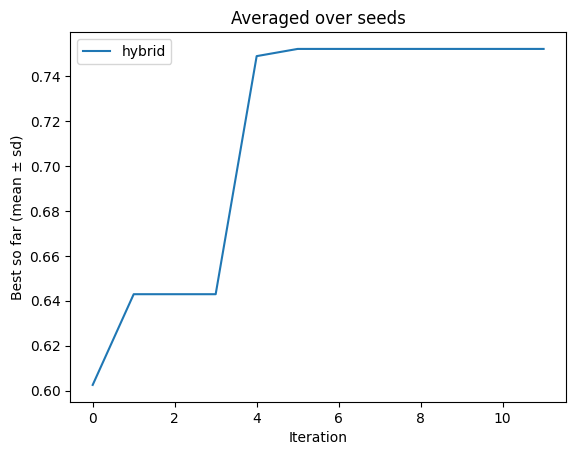

In [41]:
flat_llm = run_hybrid(
    n_init=1, n_iter=12, seed=34,
    obj=franke_hard_torch,
    readout_source="flat",     # <- enables LLM-built priors
    use_controller_anchors=False,
    model = "gpt-4o-mini",
    debug_llm=True            # <- prints LLM explanation summaries
)
plot_runs_mean(flat_llm)

LLM readout (t=-init): {'effects': {'x1': {'effect': 'decrease', 'scale': 0.5, 'confidence': 0.7, 'range_hint': [0.0, 0.4]}, 'x2': {'effect': 'decrease', 'scale': 0.5, 'confidence': 0.7, 'range_hint': [0.0, 0.4]}}, 'interactions': [], 'bumps': [{'mu': [0.9108170866966248, 0.5012379288673401], 'sigma': 0.1, 'amp': 0.2}]}
LLM readout (t=0): {'effects': {'x1': {'effect': 'decrease', 'scale': 0.5, 'confidence': 0.7, 'range_hint': [0.0, 0.4]}, 'x2': {'effect': 'decrease', 'scale': 0.5, 'confidence': 0.7, 'range_hint': [0.0, 0.4]}}, 'interactions': [], 'bumps': [{'mu': [0.9108170866966248, 0.5012379288673401], 'sigma': 0.1, 'amp': 0.2}]}
y_best = 0.6025629639625549
LLM readout (t=1): {'effects': {'x1': {'effect': 'decrease', 'scale': 0.4, 'confidence': 0.6, 'range_hint': [0.0, 0.4]}, 'x2': {'effect': 'decrease', 'scale': 0.4, 'confidence': 0.6, 'range_hint': [0.0, 0.4]}}, 'interactions': [], 'bumps': [{'mu': [0.035388700664043427, 0.011572722345590591], 'sigma': 0.1, 'amp': 0.2}]}
y_best = 0

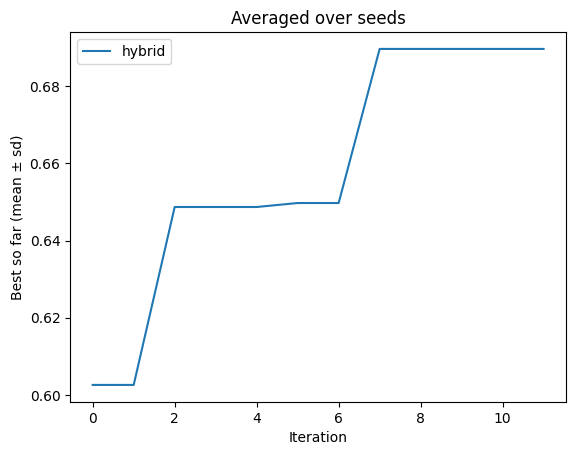

In [42]:
import json, os

hyb_llm = run_hybrid(
    n_init=1,
    n_iter=12,
    seed=34,
    obj=franke_hard_torch,
    readout_source="llm",          # important: enables LLM + logging
    use_controller_anchors=False,  # optional; keep off if isolating readout effects
    debug_llm=True,               # print LLM readouts to console if True
    model="gpt-4o-mini",               # or your chosen model
    log_json_path="logs/hybrid_llm_seed11.json"
)

plot_runs_mean(hyb_llm)

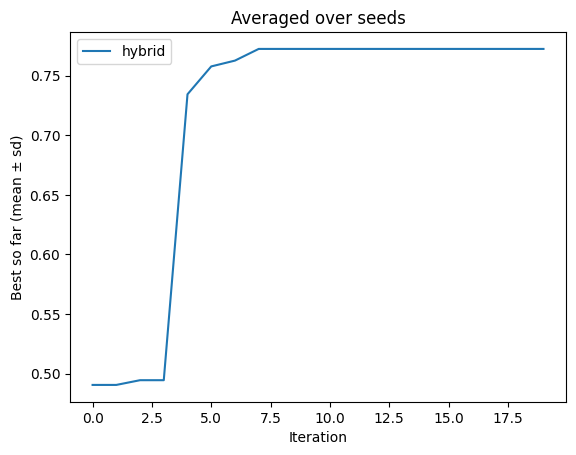

In [3]:
plot_runs_mean(hyb_llm)

In [51]:
hyb_flat

,iter,x1,x2,y,best_so_far,method
0,-3,0.718885,0.866132,-0.053608,0.392939,hybrid
1,-2,0.343158,0.495431,0.166535,0.392939,hybrid
2,-1,0.133355,0.504297,0.392939,0.392939,hybrid
3,0,0.003525,0.369929,0.573965,0.573965,hybrid
4,1,0.037553,0.012906,0.604581,0.604581,hybrid
5,2,0.000839,0.187629,0.756934,0.756934,hybrid
6,3,0.172962,0.171221,0.307522,0.756934,hybrid
7,4,0.184555,0.979216,0.069811,0.756934,hybrid
8,5,0.955923,0.028202,-0.064545,0.756934,hybrid
9,6,0.016095,0.200158,0.754511,0.756934,hybrid


In [2]:
hyb_llm = run_hybrid(
    n_init=3, n_iter=10, seed=540, obj=franke_hard_torch,
    readout_source="llm",
    use_controller_anchors=False,     # keep False initially
    debug_llm=True,                    # prints each readout JSON
    model = "gpt-4o-mini"
)

LLM readout (t=-init): {'effects': {'x1': {'effect': 'nonmonotone-peak', 'scale': 1.0, 'confidence': 0.99, 'range_hint': [0.5, 0.6]}, 'x2': {'effect': 'nonmonotone-peak', 'scale': 1.0, 'confidence': 0.99, 'range_hint': [0.15, 0.25]}}, 'interactions': [{'pair': ['x1', 'x2'], 'type': 'synergy', 'confidence': 0.95}], 'bumps': [{'mu': [0.5576707124710083, 0.15277816355228424], 'sigma': 0.1, 'amp': 0.2}]}
LLM readout (t=0): {'effects': {'x1': {'effect': 'nonmonotone-peak', 'scale': 1.0, 'confidence': 0.99, 'range_hint': [0.0, 0.05]}, 'x2': {'effect': 'nonmonotone-peak', 'scale': 1.0, 'confidence': 0.99, 'range_hint': [0.16, 0.24]}}, 'interactions': [{'pair': ['x1', 'x2'], 'type': 'synergy', 'confidence': 0.95}], 'bumps': [{'mu': [0.025, 0.2], 'sigma': 0.1, 'amp': 0.2}]}
y_best = 0.6857933402061462
LLM readout (t=1): {'effects': {'x1': {'effect': 'nonmonotone-peak', 'scale': 1.0, 'confidence': 0.99, 'range_hint': [0.0, 0.05]}, 'x2': {'effect': 'nonmonotone-peak', 'scale': 1.0, 'confidence': 

In [3]:
hyb_llm

,iter,x1,x2,y,best_so_far,method
0,-3,0.261242,0.727315,0.200610,0.416941,hybrid
1,-2,0.557671,0.152778,0.416941,0.416941,hybrid
2,-1,0.932330,0.936375,0.026727,0.416941,hybrid
3,0,0.332878,0.056104,0.328060,0.416941,hybrid
4,1,0.952957,0.153976,0.010853,0.416941,hybrid
5,2,0.493823,0.170728,0.431464,0.431464,hybrid
6,3,0.520143,0.079683,0.523239,0.523239,hybrid
7,4,0.544274,0.020322,0.426190,0.523239,hybrid
8,5,0.534698,0.465549,0.030007,0.523239,hybrid
9,6,0.499868,0.076745,0.501840,0.523239,hybrid


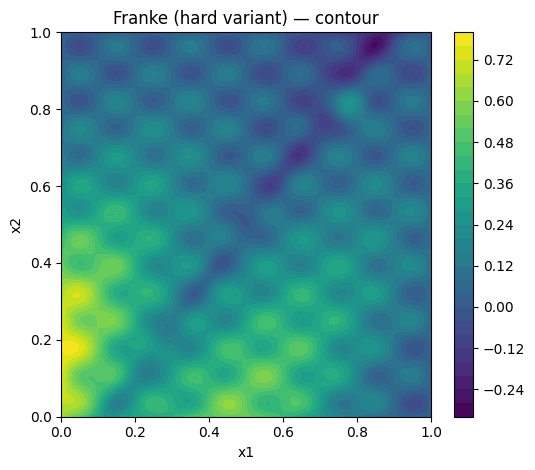

In [27]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_franke_hard(grid_n: int = 201,
                     rotate_deg: float = 35.0,
                     anisotropy=(1.0, 0.35),
                     ripple_amp: float = 0.10,
                     ripple_freq=(5, 7),
                     distractor_amp: float = 0.25,
                     distractor_mu=(0.78, 0.82),
                     distractor_sigma: float = 0.035,
                     ridge_depth: float = 0.12,
                     ridge_dir=(0.8, -0.6),
                     ridge_sigma: float = 0.025):
    """Contour plot for the harder Franke variant."""
    device = torch.device("cpu")
    dtype = torch.float32

    def franke_torch(X):
        x, y = X[..., 0], X[..., 1]
        t1 = 0.75 * torch.exp(-(9*x - 2)**2 / 4.0 - (9*y - 2)**2 / 4.0)
        t2 = 0.75 * torch.exp(-(9*x + 1)**2 / 49.0 - (9*y + 1)**2 / 10.0)
        t3 = 0.50 * torch.exp(-(9*x - 7)**2 / 4.0 - (9*y - 3)**2 / 4.0)
        t4 = 0.20 * torch.exp(-(9*x - 4)**2 - (9*y - 7)**2)
        return (t1 + t2 + t3 - t4)

    def rotate_anisowarp(X, center=(0.5, 0.5), deg=35.0, scale=(1.0, 0.35)):
        cx, cy = center
        th = math.radians(deg)
        R = torch.tensor([[math.cos(th), -math.sin(th)],
                          [math.sin(th),  math.cos(th)]], device=device, dtype=dtype)
        S = torch.tensor([[scale[0], 0.0],[0.0, scale[1]]], device=device, dtype=dtype)
        Xc = X - torch.tensor([cx, cy], device=device, dtype=dtype)
        return (Xc @ R.t()) @ S.t() + torch.tensor([cx, cy], device=device, dtype=dtype)

    # grid
    xs = torch.linspace(0, 1, grid_n, dtype=dtype, device=device)
    xx, yy = torch.meshgrid(xs, xs, indexing="xy")
    XY = torch.stack([xx, yy], dim=-1)              # (N,N,2)

    # 1) warp then base Franke
    Xw = rotate_anisowarp(XY, deg=rotate_deg, scale=anisotropy)
    base = franke_torch(Xw)

    # 2) ripples (many local optima)
    kx, ky = ripple_freq
    rip = ripple_amp * torch.sin(2*math.pi*kx*XY[...,0]) * torch.sin(2*math.pi*ky*XY[...,1])

    # 3) sharp distractor peak
    mu = torch.tensor(distractor_mu, device=device, dtype=dtype)
    dist = distractor_amp * torch.exp(-0.5 * torch.sum(((XY - mu)/distractor_sigma)**2, dim=-1))

    # 4) thin ridge valley
    v = torch.tensor(ridge_dir, device=device, dtype=dtype)
    v = v / torch.norm(v)
    proj = torch.sum((XY - 0.5) * v, dim=-1)
    ridge = -ridge_depth * torch.exp(-0.5 * (proj / ridge_sigma)**2)

    Z = (base + rip + dist + ridge).cpu().numpy()

    # plot
    fig, ax = plt.subplots(figsize=(5.5, 4.8))
    cs = ax.contourf(xx.cpu().numpy(), yy.cpu().numpy(), Z, levels=30)
    fig.colorbar(cs, ax=ax)
    ax.set_xlabel("x1"); ax.set_ylabel("x2")
    ax.set_title("Franke (hard variant) — contour")
    plt.tight_layout()
    return fig, ax

# call it
fig, ax = plot_franke_hard(grid_n=201)


In [58]:
# --- Manual BO: utilities (self-contained; uses your existing imports) ---

import numpy as np
import pandas as pd
import torch
from torch import Tensor
from botorch.models import SingleTaskGP
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.fit import fit_gpytorch_mll
from botorch.utils.sampling import draw_sobol_samples
from gpytorch.mlls import ExactMarginalLogLikelihood

import matplotlib.pyplot as plt

# Try to reuse global DEVICE/DTYPE if defined; otherwise set defaults
try:
    DEVICE
except NameError:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    DTYPE
except NameError:
    DTYPE = torch.float32

def init_manual_session(obj, n_init: int = 6, seed: int = 0, bounds=None):
    """Create initial design (Sobol) and evaluate the objective."""
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    if bounds is None:
        bounds = torch.stack([torch.zeros(2, device=DEVICE, dtype=DTYPE),
                              torch.ones(2,  device=DEVICE, dtype=DTYPE)])
    X = draw_sobol_samples(bounds=bounds, n=n_init, q=1, seed=seed).squeeze(1).to(DEVICE, DTYPE)
    Y = obj(X)
    return X, Y, bounds

def fit_gp(X: Tensor, Y: Tensor) -> SingleTaskGP:
    gp = SingleTaskGP(X, Y).to(DEVICE)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp).to(DEVICE)
    fit_gpytorch_mll(mll)
    return gp

def build_pool(bounds: Tensor, n: int = 256, seed: int = 0, anchors=None) -> Tensor:
    """Sobol pool + optional anchors (clamped into [0,1]^2)."""
    pool = draw_sobol_samples(bounds=bounds, n=n, q=1, seed=seed).squeeze(1).to(DEVICE, DTYPE)
    if anchors:
        A = torch.tensor(anchors, device=DEVICE, dtype=DTYPE).clamp(0.0, 1.0)
        pool = torch.cat([pool, A], dim=0)
    return pool

def suggest_next_ei(gp: SingleTaskGP, best_f: float, pool: Tensor):
    """Compute EI on a pool and return best x, EI values, and a DataFrame of top-10."""
    EI = ExpectedImprovement(model=gp, best_f=best_f, maximize=True)
    with torch.no_grad():
        ei_vals = EI(pool.unsqueeze(1)).reshape(-1)  # q=1
        idx = int(torch.argmax(ei_vals))
        x_next = pool[idx]
    # small report of top-10
    topk = torch.topk(ei_vals, k=min(10, ei_vals.numel()))
    rows = [{"rank": i+1,
             "x1": float(pool[j,0]), "x2": float(pool[j,1]),
             "EI": float(ei_vals[j].item())}
            for i, j in enumerate(topk.indices.tolist())]
    return x_next, ei_vals, pd.DataFrame(rows)

def update_dataset(X: Tensor, Y: Tensor, x_new: Tensor, obj) -> tuple[Tensor, Tensor]:
    y_new = obj(x_new.unsqueeze(0)).squeeze(0)
    X2 = torch.cat([X, x_new.unsqueeze(0)], dim=0)
    Y2 = torch.cat([Y, y_new.unsqueeze(0)], dim=0)
    return X2, Y2

# ---------- Visualization ----------

def viz_ei_surface(gp: SingleTaskGP, best_f: float, X: Tensor,
                   anchors=None, extra_points: dict = None, grid_n: int = 80,
                   title: str = "EI surface (manual step)"):
    """Contour of EI on [0,1]^2 + samples + anchors + optional extra points."""
    xs = torch.linspace(0, 1, grid_n, device=DEVICE, dtype=DTYPE)
    xx, yy = torch.meshgrid(xs, xs, indexing="xy")
    grid = torch.stack([xx, yy], dim=-1).reshape(-1, 2)

    EI = ExpectedImprovement(model=gp, best_f=best_f, maximize=True)
    with torch.no_grad():
        ei_vals = EI(grid.unsqueeze(1)).reshape(grid_n, grid_n).cpu().numpy()

    plt.figure(figsize=(6.2, 5.4))
    cs = plt.contourf(xx.cpu(), yy.cpu(), ei_vals, levels=30)
    plt.colorbar(cs, label="EI")
    # observed points
    plt.scatter(X[:,0].cpu(), X[:,1].cpu(), s=18, edgecolor="k", facecolor="white", label="observed")
    # anchors
    if anchors:
        A = np.array(anchors); plt.scatter(A[:,0], A[:,1], s=60, marker="*", label="anchors")
    # extras (e.g., baseline/anchored suggestions)
    if extra_points:
        for name, pt in extra_points.items():
            p = np.array(pt); plt.scatter([p[0]], [p[1]], s=70, marker="X", label=name)
    plt.xlim(0,1); plt.ylim(0,1); plt.legend()
    plt.title(title); plt.xlabel("x1"); plt.ylabel("x2"); plt.show()

def viz_posterior(gp: SingleTaskGP, X: Tensor, which: str = "mean", grid_n: int = 80,
                  title: str = "Posterior"):
    """Contour of posterior mean or variance."""
    xs = torch.linspace(0, 1, grid_n, device=DEVICE, dtype=DTYPE)
    xx, yy = torch.meshgrid(xs, xs, indexing="xy")
    grid = torch.stack([xx, yy], dim=-1).reshape(-1, 2)
    with torch.no_grad():
        post = gp.posterior(grid.unsqueeze(1))
        if which == "mean":
            Z = post.mean.reshape(grid_n, grid_n).cpu().numpy()
            zlab = "mean"
        else:
            Z = post.variance.reshape(grid_n, grid_n).cpu().numpy()
            zlab = "variance"
    plt.figure(figsize=(6.2, 5.4))
    cs = plt.contourf(xx.cpu(), yy.cpu(), Z, levels=30)
    plt.colorbar(cs, label=zlab)
    plt.scatter(X[:,0].cpu(), X[:,1].cpu(), s=18, edgecolor="k", facecolor="white", label="observed")
    plt.xlim(0,1); plt.ylim(0,1); plt.legend()
    plt.title(f"Posterior {zlab}"); plt.xlabel("x1"); plt.ylabel("x2"); plt.show()


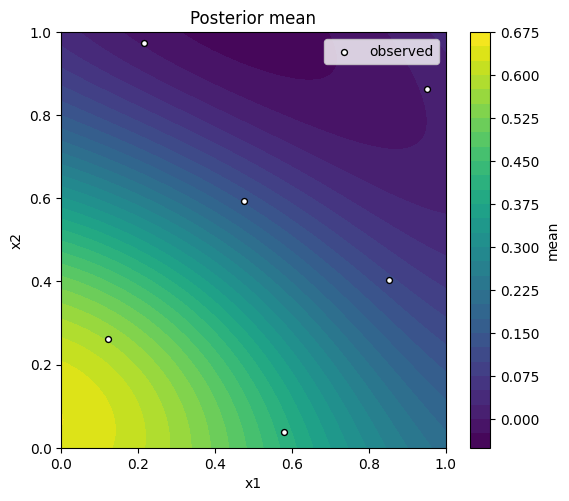

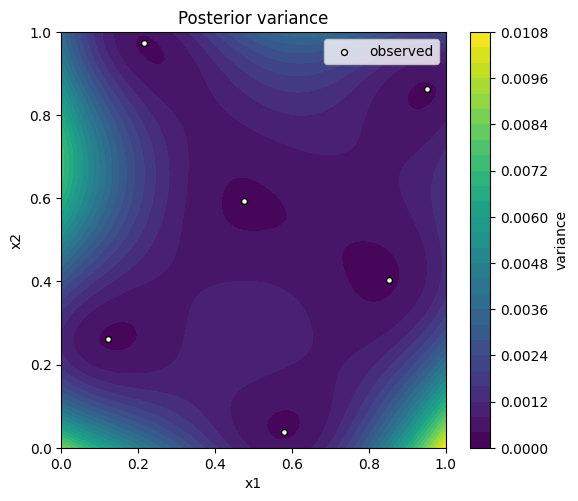

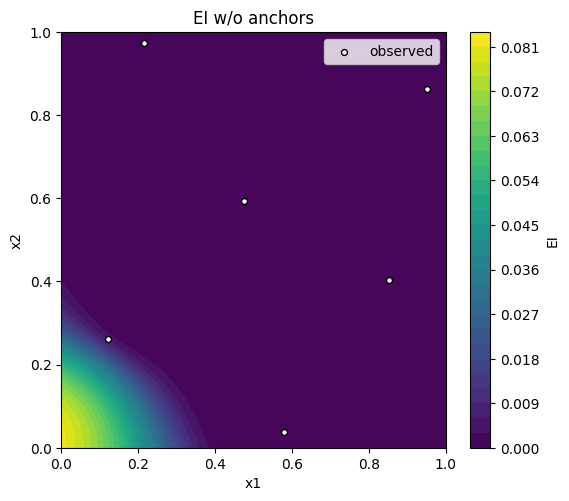

Suggested w/o anchors: (0.12045787274837494, 0.2614422142505646)
Suggested WITH anchors: (0.0, 0.20000000298023224)


,rank,x1,x2,EI
0,1,0.120458,0.261442,5.537761e-03
1,2,0.314215,0.172459,7.814607e-04
2,3,0.578763,0.037122,2.193233e-21
3,4,0.475107,0.592524,0.000000e+00
4,5,0.685762,0.341105,0.000000e+00
5,6,0.853759,0.403495,0.000000e+00
6,7,0.257924,0.787076,0.000000e+00
7,8,0.742083,0.695453,0.000000e+00
8,9,0.950670,0.862344,0.000000e+00
9,10,0.214945,0.974182,0.000000e+00


,rank,x1,x2,EI
0,1,0.000000,0.200000,5.394543e-02
1,2,0.120458,0.261442,5.537761e-03
2,3,0.314215,0.172459,7.814607e-04
3,4,0.850000,0.150000,2.138746e-17
4,5,0.578763,0.037122,2.193233e-21
5,6,0.853759,0.403495,0.000000e+00
6,7,0.742083,0.695453,0.000000e+00
7,8,0.214945,0.974182,0.000000e+00
8,9,0.475107,0.592524,0.000000e+00
9,10,0.950670,0.862344,0.000000e+00


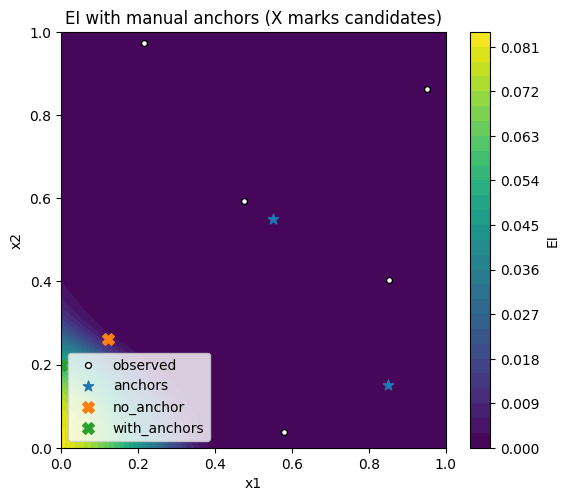

In [ ]:
# --- Example manual step ---

# Choose your objective (whatever you imported in your session)
try:
    obj = franke_hard_torch  # if you imported it earlier
except NameError:
    obj = franke_torch       # fallback

# 1) Initialize (only once)
X, Y, bounds = init_manual_session(obj=obj, n_init=6, seed=0)

# 2) Fit GP and visualize EI/Posterior
gp = fit_gp(X, Y)
best_f = float(Y.max().item())

viz_posterior(gp, X, which="mean", grid_n=90)
viz_posterior(gp, X, which="var", grid_n=90)
viz_ei_surface(gp, best_f, X, anchors=None, title="EI w/o anchors", grid_n=90)

# 3) Define ANCHORS manually for this step (edit these!)
anchors = [
    [0.0, 0.2],   # exploit/incumbent-ish
    [0.85, 0.15],   # explore boundary
    [0.55, 0.55],   # high-uncertainty mid
]

# 4) Build pools
pool_base_n = 256
pool_no = build_pool(bounds, n=pool_base_n, seed=0, anchors=None)
pool_yes = build_pool(bounds, n=pool_base_n, seed=0, anchors=anchors)

# 5) Get suggestions
x_no, ei_no, top_no = suggest_next_ei(gp, best_f, pool_no)
x_yes, ei_yes, top_yes = suggest_next_ei(gp, best_f, pool_yes)

print("Suggested w/o anchors:", (float(x_no[0]), float(x_no[1])))
print("Suggested WITH anchors:", (float(x_yes[0]), float(x_yes[1])))

display(top_no.head(10))
display(top_yes.head(10))

# 6) Visualize EI with both candidates and anchors overlaid
viz_ei_surface(
    gp, best_f, X,
    anchors=anchors,
    extra_points={"no_anchor": x_no.cpu().numpy(), "with_anchors": x_yes.cpu().numpy()},
    grid_n=100,
    title="EI with manual anchors (X marks candidates)"
)
